# Bayes theorem and splines <a class=tocskip></a>

### Christian Holm Christensen <a class=tocskip></a>

## Bayesian estimates 

Here we use Bayes theorem 

$$ P(A|B) = \frac{P(B|A)P(A)}{P(B)}\quad,$$ 

where 

- The _posterior_ $P(A|B)$ - the probability of $A$ given $B$ 
- The _likelihood_ $P(B|A)$ - the probability of $B$ given $A$ 
- The _prior_ $P(A)$ - the probability of $A$ 
- The _marginal likelihood_ $P(B)$ 

To remind ourselves what the meaning of these let us delve a little in to these and consider the case where we have some theory $A$ that purports to explain some data $B$.   Then 

- $P(\mathrm{data}|\mathrm{theory})$ is the likelihood of the data if the theory is correct.  Suppose the theory is described by the probability density function (PDF) $f$, then $P(\mathrm{data}|\mathrm{theory})$ is the likelihood of observations $\mathrm{data}$ given this PDF

  $$P(\mathrm{data}|\mathrm{theory}) = L(\mathrm{data},f) = \prod_{x\in \mathrm{data}} f(x)\quad.$$ 
  
- The _prior_ $P(\mathrm{theory})$ is the probability that the theory is correct.  This is not easily formalised, and our choice of prior is often quite subjective.  However, one can, for example adopt an iterative approach to adjust the prior. 

- The _marginal likelihood_ $P(\mathrm{data})$ is in this case the probability of the observations.  Since the observations _were_ made, one can think of this as _unity_ 

  $$P(\mathrm{data}) = 1\quad,$$ 
  
  or some other appropriate normalisation constant.  However, the marginal likelihood is not always this trivial and we cannot assume that it is constant all the time. 
  
- The _posterior_ $P(\mathrm{theory}|\mathrm{data})$ is then the probability of the theory given the observed data.  This is what we are after - given some data how likely is the theory to be true. 



### The Problem

We have a population of _unknown_ size $N$, but which contains exactly $K$ _successes_.  We extract $n$ samples, of which we find $k$ as success.  Given this, we would like to estimate the population size $N$.   We can think of it this way

- We have population of $N-K$ fish _which are known not to be cot_
- We release $K$ cot into that population which is now of size $N$.
- Next, we catch $n$ fish and count $k$ cot amongst these.  All the fish are released. 
- What can we say about the population size $N$? 

Let us write this up in terms of Bayes theorem 

$$P(N|k\in n,K) = \frac{P(k \in n,K|N)P(N)}{P(k \in n,K}\quad.$$

At first, we will set the marginal likelihood $P(k \in K)=1$.  

The sampling we are doing is described by [_hypergeometric_](https://en.wikipedia.org/wiki/Hypergeometric_distribution) PDF (or rather probability _mass_ function (PMF) since it is a discrete distribution) 

$$f(k;n,K,N) = {{{K \choose k}{{N-K} \choose {n-k}}} \over {N \choose n}}\quad,$$

where 

$$\binom{a}{b} = \frac {a!}{b!(a-b)!}\quad,$$ 

is the [_binomial coefficient_](https://en.wikipedia.org/wiki/Binomial_coefficient) which tells us in how many ways we can extract $a$ samples from a population of size $b$.  Thus, our _likelihood_ is 

$$P(k \in n,K|N) = L(\{k_i\};n,K,N) = \prod_{i=1}^{M} f(k_i;n,K,N)\quad,$$

where $M$ is the number of times we repeat the experiment. 

_SymPy_ has a powerful statistics module that allows us to define random variables - including a hypergeometric random variable.  We must, however, provide fixed numbers for $n,K,N$, so let us set 

$$n=60\quad K=50\quad N=100\quad,$$ 

and look at the PMF.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import sympy as sy
import sympy.stats
sy.init_printing()
hg = sy.stats.Hypergeometric('k',500,50,60)
pmf = np.array([(int(k.evalf()),float(n.evalf())) 
                for k,n in sy.stats.density(hg).dict.items()])
plt.plot(pmf[:,0],pmf[:,1],drawstyle='steps')
plt.xlabel('$k$')
plt.ylabel(r'$P(k)$');

As described above, we have no clear idea of what our prior should be.   A simple choice would be to say that all $N$ are equally likely, so that $P(N)=c$ with $c$ a constant. 

Our posterior then becomes 

$$P(N|k\in n,K) = \frac{\left(\prod_{i=1}^{M} f(k_i;n,K,N)\right)c}{1} = c\prod_{i=1}^{M} f(k_i;n,K,N)\quad.$$ 

### Estimation of $N$

Suppose we have 

$$k=10,15\quad n=60\quad K=50\quad P(N)=c,1/N\quad,$$ 

what is our estimate of $N$ in each case?  We want to plot 

- The prior 
- The likelihood 
- The posterior 

in each of the four cases, and give an estimate of $N$ in all cases.  We define a simple function to likelihood and prior for given $k,N$

In [2]:
def lh(k,N,K=50,n=60):
    from scipy.special import binom
    return binom(K,k)*binom(N-K,n-k)/binom(N, n)

We want to evaluate this function, as well as the prior, over a range of $N$'s and return all three numbers: the likelihood, the prior, and the posterior - all for a given $k$ and a given prior $P$ (a function of $N$).

In [3]:
def post(k,P,N,K=50,n=60):
        
    l  = lh(k,N,K,n)
    p  = P(N)
    l[np.isnan(l)] = 0
    return N,l,p,l*p

Let us also make a function that plots the result and finds the maximum

In [4]:
def plotpost(k,P,NP,N=None,K=50,n=60,ax=None):
    if ax is None:
        ax = plt.gca()
        
    if N is None:
        N = np.arange(2*K,20*K)
    
    N, l, pr, po = post(k,P,N,K,n)
    
    l  /= l.sum()
    pr /= pr.sum()
    po /= po.sum()
    
    best = N[po.argmax()]
    lest = N[l.argmax()]
    
    ax.plot(N,pr,':',  label=r'Prior $P(N)={}$'.format(NP))
    ax.plot(N,l, '--', label=r'Likelihood $N={}$'.format(lest),
            drawstyle='steps',lw=3)
    ax.plot(N,po,'-',  label=r'Posterior $N={}$'.format(best))
    
    ax.set_xlabel('$N$')
    ax.set_ylabel('$P$ (a.u.)')
    ax.legend(title=f'$k={k}$')
    ax.grid()
    
    return best

We make a function that will plot the analysis for different combinations of $k$ and our prior.  The function also accepts keyword arguments passed on to the `plotpost` function defined above. 

In [5]:
def plotposts(ks,prs,nps,figsize=(8,8),**kwargs):
    comp = [(k,p,n) for p,n in zip(prs,nps) for k in ks]  
    
    nk  = len(ks)
    npr = len(prs)
    fig, ax = plt.subplots(ncols=nk,nrows=npr,squeeze=False,
                           figsize=figsize,
                           sharex=True,sharey=True,
                           gridspec_kw=dict(hspace=0,wspace=0))
    
    for a, (k,p,n) in zip(ax.ravel(),comp):
        plotpost(k,p,n,ax=a,**kwargs)
    
    plt.tight_layout()

We can know do our analysis.  We calculate the combinations we want 

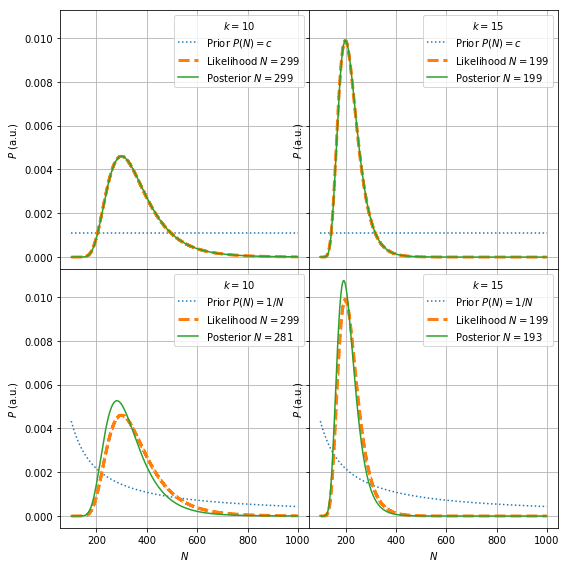

In [6]:
ks   = [10, 15]
prs  = [lambda N:1.*np.ones_like(N), lambda N: 1/N]
nps  = ['c','1/N']
plotposts(ks,prs,nps)

### Fish in a lake

We have a lake with a volume of 

$$V = (5000\pm300)\,\mathrm{m}^3\quad,$$ 

and we believe that the density of fish in the lake is 

$$\rho = \frac{1}{(10\pm 1)\,\mathrm{m^3}}\quad,$$ 

and so our estimate of the number of fish in the lake is 

$$N = V\rho = (5000\pm300)\,\mathrm{m}^3 \frac{1}{(10\pm 1)\,\mathrm{m^3}} 
 = 500 \pm 60\quad,$$
 
rounded to one significant digit.  

Given that the sample is large, we change our prior to be a normal distribution with $\mu=500$ and $\sigma=60$.  We also set 

$$K=50\quad n=30\quad k=4,8\quad.$$

Let us plot this 

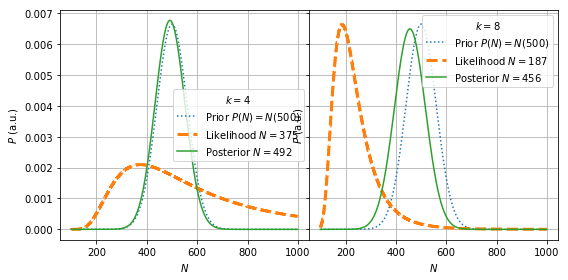

In [7]:
import scipy as sp
import scipy.stats
ks  = [4,8]
prs = [lambda N: sp.stats.norm.pdf(N,500,60)]
nps = ['N(500,60)']
plotposts(ks,prs,['N(500)'],figsize=(8,4),n=30,K=50)

Let us now change the $\sigma$ of our prior to be 2 or 3 times larger.  We will plot for $\sigma$ too, for reference. 

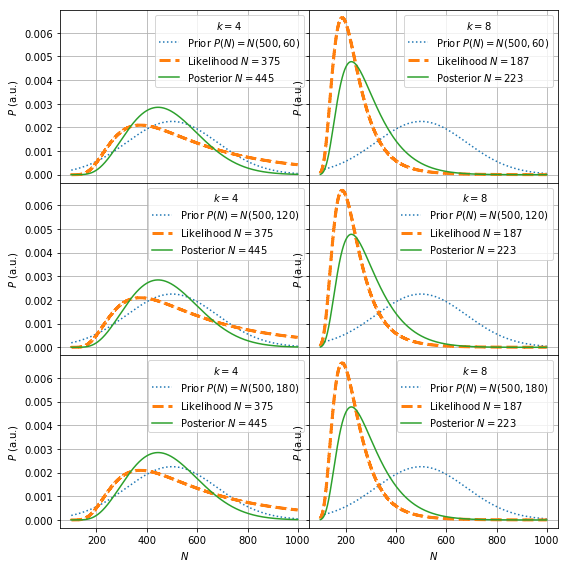

In [8]:
fs  = range(1,4)
nps = [f'N(500,{f*60})' for f in fs]
prs = [ lambda N: sp.stats.norm.pdf(N,500,f*60) for f in fs]
plotposts(ks,prs,nps,figsize=(8,8),n=30,K=50)

Suppose we had another estimate of the density of fish - say 

$$\rho' = \frac{1}{(9.2\pm0.2)\,\mathrm{m}^3}\quad.$$ 

Then, it would change the parameters of our prior so that 

$$N = V\rho' = 540\pm 30\quad,$$

again rounded to one significant digit.  Let us see how that changes things around 

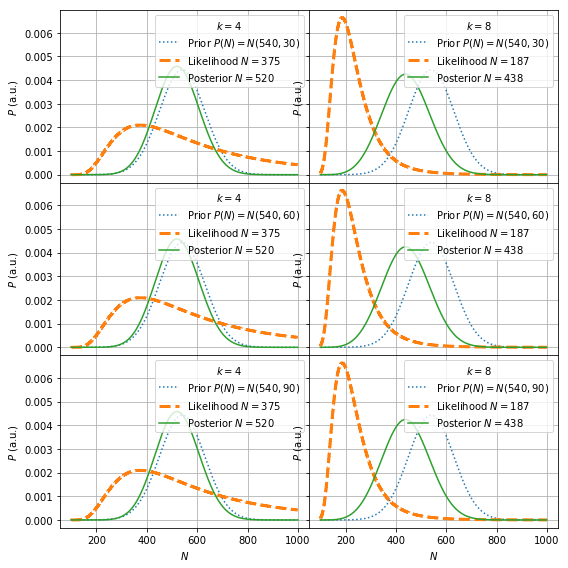

In [9]:
fs  = range(1,4)
nps = [f'N(540,{f*30})' for f in fs]
prs = [ lambda N: sp.stats.norm.pdf(N,540,f*30) for f in fs]
plotposts(ks,prs,nps,figsize=(8,8),n=30,K=50)

An extreme case is 

$$k=12\quad\mu=500\quad\sigma=61\quad.$$

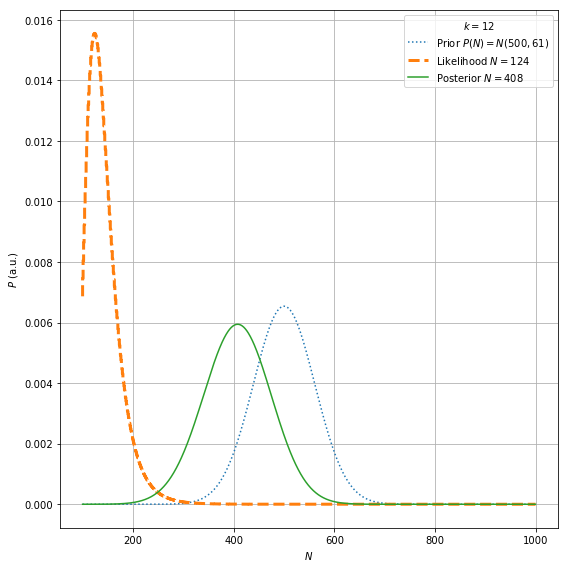

In [10]:
ks  = [12]
nps = [f'N(500,61)']
prs = [ lambda N: sp.stats.norm.pdf(N,500,61)]
plotposts(ks,prs,nps,figsize=(8,8),n=30,K=50)

There is a _huge_ discrepancy between the likelihood estimate and Bayesian estimate of $N$.  In fact, the Bayesian estimate of $N=408$ is _very_ unlikely given the likelihood estimate  $N=124$. 

In [11]:
q408 = lh(12,np.arange(408,10000),K=50,n=30).sum()
print(f'Probability of N>=408 by likelihood {q408*100:.3f}%')

Probability of N>=408 by likelihood 0.192%


that is to say, _very_ unlikely. 

## Splines

### Antarctic dust 

Let us look at some dust-logger data from Antarctica 

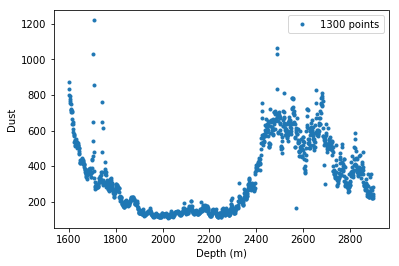

In [12]:
dust = np.genfromtxt('DustLog_forClass.dat')
plt.plot(dust[:,0],dust[:,1],'.',label=f'{len(dust)} points')
plt.xlabel('Depth (m)')
plt.ylabel('Dust');
plt.legend()

Let us plot the data, a linear interpolation between points, and a cubic spline interpolation 

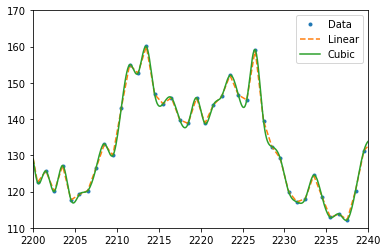

In [13]:
import scipy.interpolate

lne = sp.interpolate.interp1d(dust[:,0],dust[:,1],kind='linear')
spl = sp.interpolate.interp1d(dust[:,0],dust[:,1],kind='cubic')

fine = np.linspace(dust[:,0].min(),dust[:,0].max(),10*len(dust))

plt.plot(dust[:,0],dust[:,1],'.',label='Data')
plt.plot(fine,lne(fine),'--',label='Linear')
plt.plot(fine,spl(fine),'-', label='Cubic')

plt.xlim(2200,2240)
plt.ylim(110,170)
plt.legend();

### A PDF 

We read in the data of an unknown PDF 

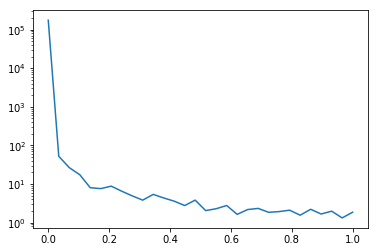

In [14]:
pdf = np.genfromtxt('SplineCubic.txt')
plt.plot(pdf[:,0],pdf[:,1],label='PDF')
plt.yscale('log')

We know some noise is added on top of the data, so we'd like to make some interpolations of the data.  We do a linear and cubic interpolation. To make life easier, we write a small function 

In [15]:
def inter(data,xfactor=10,s=None):
    from scipy.interpolate import UnivariateSpline as Spline
    from numpy import linspace, sqrt
    
    if s is None: 
        s = len(data) + sqrt(len(data)*2)
    
    lne = Spline(data[:,0],data[:,1],k=1,s=s)
    qua = Spline(data[:,0],data[:,1],k=2,s=s)
    cub = Spline(data[:,0],data[:,1],k=3,s=s)

    fine = linspace(data[:,0].min(),data[:,0].max(),xfactor*len(data))

    return fine, lne, qua, cub, s

In [16]:
def plotinter(data,s=None,figsize=(8,4),l=[1e-5,0.03],h=[1e-2,0.1],log=True):
    fine, lne, qua, cub, s  = inter(pdf,s=s)
    
    fig, ax = plt.subplots(ncols=2,figsize=figsize)
    
    ax[0].plot(data[:,0],data[:,1],'o',label='PDF')
    ax[0].plot(fine,lne(fine),'--',label='Linear')
    ax[0].plot(fine,qua(fine),'-.',label='Quadratic')
    ax[0].plot(fine,cub(fine),'-',label='Cubic')
    if log: ax[0].set_yscale('log')
    ax[0].legend(title=r'$s={:.2f}$'.format(s))  
    
    for ll, hh in zip(l,h):
        intg = [s.integral(ll,hh) for s in (lne,qua,cub)]
        intd = np.where(np.logical_and(data[:,0] >= ll, data[:,0] <= hh),
                        data[:,1], 0).sum()*(hh-ll)
        ax[1].plot(range(0,4),[intd]+intg,'o',label=r'$[{:.5f},{:.5f}]$'.format(ll,hh))
    
    ax[1].set_xlabel(r'$k$')
    ax[1].set_ylabel(r'$\int_{l}^{h}}dx i_k$')
    ax[1].set_xticks([0,1,2,3])
    ax[1].set_xticklabels(['Data','Linear','Quadratic','Cubic'])

    plt.tight_layout()
    plt.legend()
    
    return fine,lne,qua,cub,s

We determine the splines with $s=0$ for the smoothness parameter - meaning all data points will be "hit"

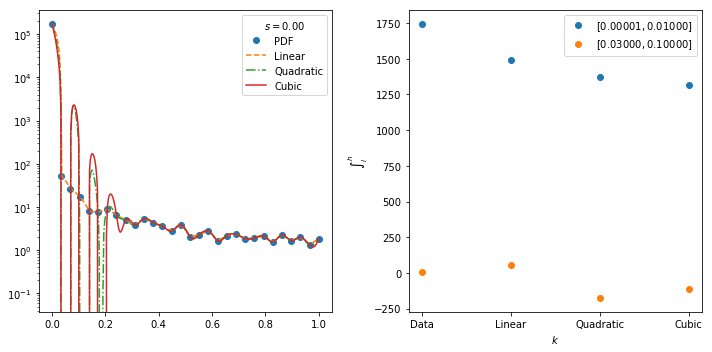

In [17]:
plotinter(pdf,s=0,figsize=(10,5));

Let us do the same for $s=N+\sqrt{2N}$ where $N$ is the number of points. 

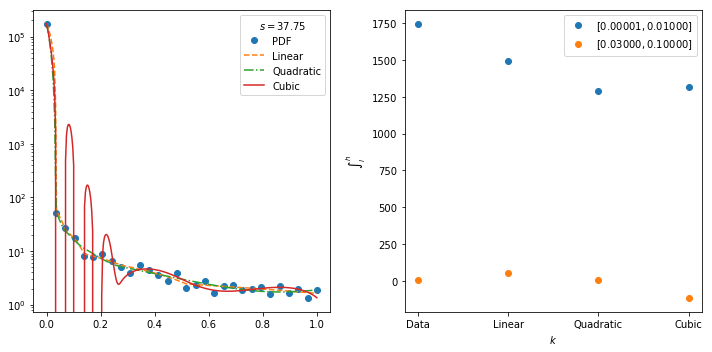

In [18]:
plotinter(pdf,figsize=(10,5));

## Neutrino oscillations 

We read in a file of the neutrino oscillation probability as a function of energy $E$. 

Got 5000 data points


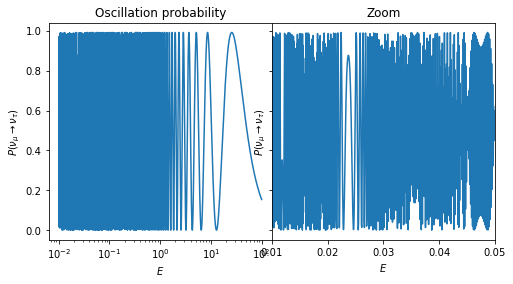

In [19]:
prob = np.genfromtxt('SplineOsc1.txt')

fig, ax = plt.subplots(ncols=2,sharey=True,
                      gridspec_kw=dict(wspace=0),
                      figsize=(8,4))
ax[0].plot(prob[:,0],prob[:,1])
ax[0].set_xlabel('$E$')
ax[0].set_xscale('log')
ax[0].set_ylabel(r'$P(\nu_\mu\rightarrow\nu_\tau)$')
ax[0].set_title('Oscillation probability')
ax[1].plot(prob[:,0],prob[:,1])
ax[1].set_xlabel('$E$')
ax[1].set_ylabel(r'$P(\nu_\mu\rightarrow\nu_\tau)$')
ax[1].set_xlim(0.01,.05)
ax[1].set_title('Zoom')
print(f'Got {len(prob)} data points')

We want to make a spline fit that describes this data.  However, a very low energies the oscillation becomes very rapid, and we better approximate the data by a constant $c=0.5$.  We start by making a function to do the cubic spline and then plot it with the data (as well as a zoom of the data).  We allow the parameter $s$ for the smoothness of the spline. 

In [20]:
def plotosc(prob,s=None,z=1):
    fin, lne, qua, cub, s = inter(prob,s=s)

    fig, ax = plt.subplots(ncols=2,sharey=True,
                          gridspec_kw=dict(wspace=0),
                          figsize=(8,4))
    ax[0].plot(prob[:,0],prob[:,1],label='Data')
    ax[0].plot(fin,cub(fin),label='Cubic')
    ax[0].set_xlabel('$E$')
    ax[0].set_xscale('log')
    ax[0].set_ylabel(r'$P(\nu_\mu\rightarrow\nu_\tau)$')
    ax[0].set_title('Oscillation probability')
    ax[0].legend()
    
    ax[1].plot(prob[:,0],prob[:,1])
    ax[1].plot(fin,cub(fin),label='Cubic')
    ax[1].set_xlabel('$E$')
    ax[1].set_ylabel(r'$P(\nu_\mu\rightarrow\nu_\tau)$')
    ax[1].set_xlim(0.01,z)
    ax[1].set_ylim(-.1, 1.3)
    ax[1].set_title(r'Zoom $s={:.2f}$'.format(s))
    ax[1].legend()

First, we use the default value of $s$ set to $N+\sqrt{2N}$ where $N$ is the number of data points. 

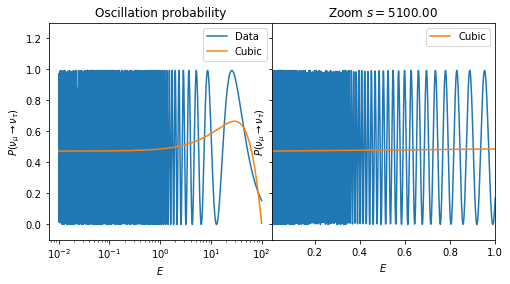

In [21]:
plotosc(prob)

This is clearly not very good.  After a bit of trial-and-error we end up with $s=350$, and get 

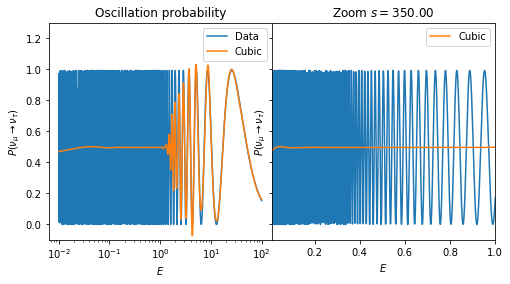

In [22]:
plotosc(prob,s=350)

Now, we could of course consider this a minimization problem and define optimize $s$ such that the difference between the spline in some region (say $E\in[0.01,0.6]$) and the constant $c=0.5$ is the least.   The function below minimizes the _objective function_ (encoded as `obj` below)

$$ f(s) = \frac{1}{N_{E<l}}\sum_{E<l}\left(c(E,s)-t\right)^2 + \frac{1}{N_{E\ge l}}\sum_{E\ge l}|c(E,s)-p(E)|\quad,$$ 

where $l$ is the cut-off, and $c(E,s),p(E)$ the cubic spline value and oscillation probability at $E$, and $t=c$ is the target constant value.  $N_{E<l},N_{E\ge l}$ is the number of point below and above the cut off, respectively.  Note, by squaring in the first sum, we give more significance to $E<l$ than above. 

In [23]:
def finds(data,tgt=.5,s=350,t=.6):
    from scipy.interpolate import UnivariateSpline as Spline
    from scipy.optimize import minimize
    
    low  = data[data[:,0]<t][:,0]
    high = data[data[:,0]>=t]
    def obj(s):
        cub = Spline(data[:,0],data[:,1],k=3,s=s)
        sval = cub(low)
        hval = cub(high[:,0])
        
        slow  = np.sum((sval - tgt)**2)/len(low)
        shigh = np.sum(np.abs(hval - high[:,1]))/len(high)
        return slow+shigh
        
    opt = minimize(obj,s)
    if not opt.success:
        print(opt.message)
    
    return t, opt.x[0], np.sqrt(opt.hess_inv[0,0])

Let us use this to find an optimal value of $s$. 

In [24]:
t, s, e = finds(prob)
print(f'Restricting line to 0.5 in below {t} gives {s:.2f}+/-{e:.2f}')

Restricting line to 0.5 in below 0.6 gives 332.60+/-4.79


Let us plot the result

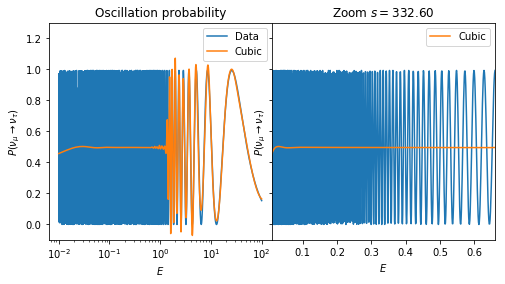

In [25]:
plotosc(prob,s=s,z=1.1*t)

An alternative, but related, approach is to perform a least squares fit to the data, but substituting values below the threshold with the target constant $c=0.5$.  This is slow due to continuous evaluation of the spline. 

In [26]:
def fits(data,tgt=.5,s=350,t=.6):
    from scipy.interpolate import UnivariateSpline as Spline
    from scipy.optimize import curve_fit
    from numpy import atleast_1d, isclose
    
    def f(x,s):
        cub   = Spline(data[:,0],data[:,1],k=3,s=s)
        return cub(x)
    
    es = data[:,0]
    ps = data[:,1].copy()
    ps[es < t] = tgt
    ret = curve_fit(f, es, ps,(s), full_output=True)
    return t,ret[0][0],np.sqrt(ret[1].diagonal()[0])

Let us do the least-squares fit

In [27]:
t,s,e = fits(prob)

Print result and plot

Restricting line to 0.5 in below 0.6 gives 331.51+/-0.18


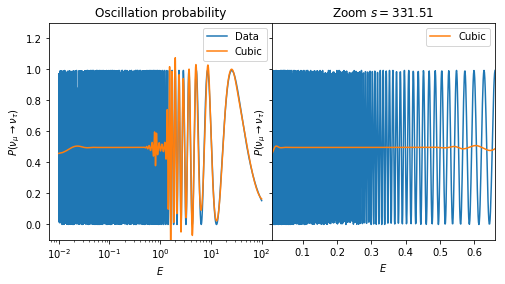

In [28]:
print(f'Restricting line to 0.5 in below {t} gives {s:.2f}+/-{e:.2f}')
plotosc(prob,s=s,z=1.1*t)

Both the direct minimisation and the least-squares fit are obtain consistent values for $s$, which isn't to surprising given a least-squares fit is essentially a minimisation.